# Feature Extraction

1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data



In [1]:
# data link - https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import os

In [3]:
import os
for dirpath, dirnames, filenames in os.walk('../../Dataset/10_food_classes_10_percent/'):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in "{dirpath}".')

There are 2 directories and 0 images in "../../Dataset/10_food_classes_10_percent/".
There are 10 directories and 0 images in "../../Dataset/10_food_classes_10_percent/test".
There are 0 directories and 250 images in "../../Dataset/10_food_classes_10_percent/test/ice_cream".
There are 0 directories and 250 images in "../../Dataset/10_food_classes_10_percent/test/chicken_curry".
There are 0 directories and 250 images in "../../Dataset/10_food_classes_10_percent/test/steak".
There are 0 directories and 250 images in "../../Dataset/10_food_classes_10_percent/test/sushi".
There are 0 directories and 250 images in "../../Dataset/10_food_classes_10_percent/test/chicken_wings".
There are 0 directories and 250 images in "../../Dataset/10_food_classes_10_percent/test/grilled_salmon".
There are 0 directories and 250 images in "../../Dataset/10_food_classes_10_percent/test/hamburger".
There are 0 directories and 250 images in "../../Dataset/10_food_classes_10_percent/test/pizza".
There are 0 dire

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = '../../Dataset/10_food_classes_10_percent/train/'
test_dir = '../../Dataset/10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print('Training Images:')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                         target_size=IMAGE_SHAPE,
                                                         batch_size=BATCH_SIZE,
                                                         class_mode='categorical')

print('Testing Images:')
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='categorical')

Training Images:
Found 750 images belonging to 10 classes.
Testing Images:
Found 2500 images belonging to 10 classes.


In [5]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f'Saving TensorBoard log files to: {log_dir}')
    return tensorboard_callback

In [6]:
import tensorflow_hub as hub

model = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2")
embeddings = model(["The rain in Spain.", "falls",
                    "mainly", "In the plain!"])

print(embeddings.shape)  #(4,128)

2023-04-09 16:18:56.937080: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(4, 128)


In [7]:
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4'
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [8]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers


In [9]:
def create_model(model_url, num_classes=10):
    """
    Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

    Args:
        model_url (str): A TensorFlow Hub feature extraction URL.
        num_classes (int): Number of output neurons in the output layer,
            should be equal to number of target classes, default 10.

    Returns:
        An uncompiled Keras Sequential model with model_url as feature extractor
        layer and Dense output layer with num_classes output neurons.
    """
    # Download the pretrained model and save it as a Keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False, # freeze the already learned patterns
                                             name='feature_extraction_layer',
                                             input_shape=IMAGE_SHAPE+(3,)) # 3 for color channels

    # Create our own model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation='softmax', name='output_layer')
    ])

    return model

In [10]:
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [11]:
train_data_10_percent.num_classes

10

In [12]:
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [13]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [14]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=int(0.25 * len(test_data)),
                                  callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                         experiment_name='resnet50v2')])

Saving TensorBoard log files to: tensorflow_hub/resnet50v2/20230409-161901
Epoch 1/5
24/24 [==============================] - 90s 4s/step - loss: 1.9363 - accuracy: 0.3240 - val_loss: 1.2517 - val_accuracy: 0.5888
Epoch 2/5
24/24 [==============================] - 55s 2s/step - loss: 0.9112 - accuracy: 0.7293 - val_loss: 0.8380 - val_accuracy: 0.7385
Epoch 3/5
24/24 [==============================] - 52s 2s/step - loss: 0.6220 - accuracy: 0.8387 - val_loss: 0.7546 - val_accuracy: 0.7500
Epoch 4/5
24/24 [==============================] - 48s 2s/step - loss: 0.4758 - accuracy: 0.8747 - val_loss: 0.6745 - val_accuracy: 0.7928
Epoch 5/5
24/24 [==============================] - 48s 2s/step - loss: 0.3925 - accuracy: 0.9107 - val_loss: 0.6690 - val_accuracy: 0.7812


In [15]:
def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('loss')
    plt.xlabel('epochs')
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('accuracy')
    plt.xlabel('epochs')
    plt.legend()


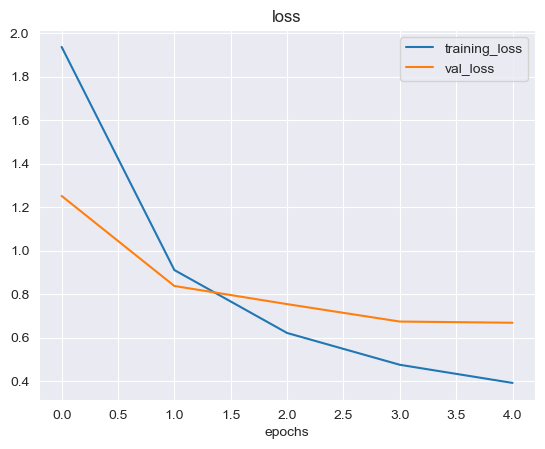

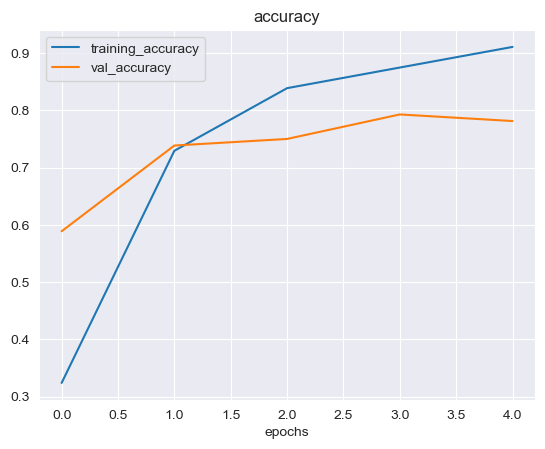

In [16]:
plot_loss(resnet_history)

In [17]:
efficientnet_model = create_model(model_url=efficientnet_url,
                                num_classes=train_data_10_percent.num_classes)

efficientnet_model.compile(loss='categorical_crossentropy',
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=['accuracy'])

efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=int(0.25 * len(test_data)),
                                              callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                     experiment_name='efficientnetb0')])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20230409-162358
Epoch 1/5
24/24 [==============================] - 21s 763ms/step - loss: 1.7866 - accuracy: 0.4867 - val_loss: 1.2535 - val_accuracy: 0.7549
Epoch 2/5
24/24 [==============================] - 18s 777ms/step - loss: 1.0189 - accuracy: 0.7560 - val_loss: 0.8365 - val_accuracy: 0.8207
Epoch 3/5
24/24 [==============================] - 18s 780ms/step - loss: 0.7429 - accuracy: 0.8413 - val_loss: 0.6673 - val_accuracy: 0.8421
Epoch 4/5
24/24 [==============================] - 18s 780ms/step - loss: 0.5997 - accuracy: 0.8600 - val_loss: 0.6242 - val_accuracy: 0.8240
Epoch 5/5
24/24 [==============================] - 19s 794ms/step - loss: 0.5052 - accuracy: 0.8840 - val_loss: 0.5543 - val_accuracy: 0.8470


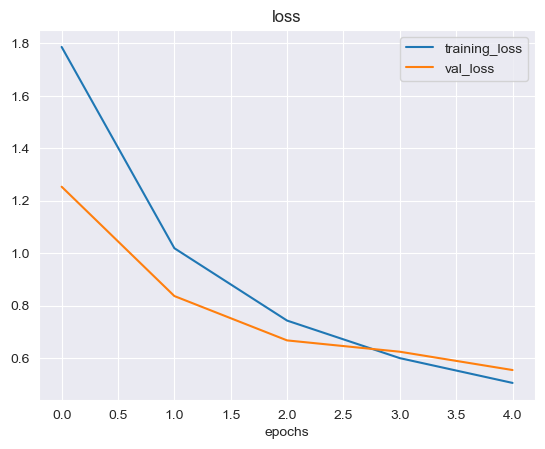

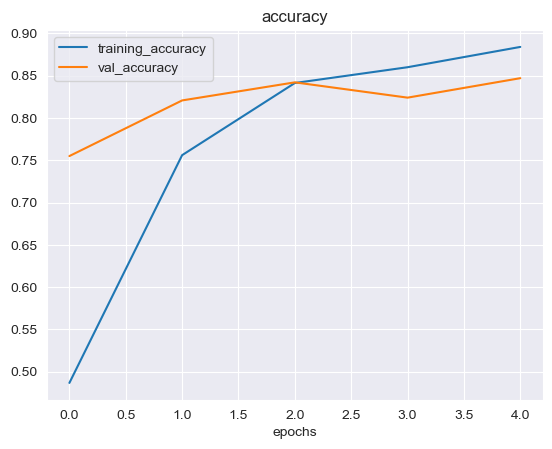

In [18]:
plot_loss(efficientnet_history)

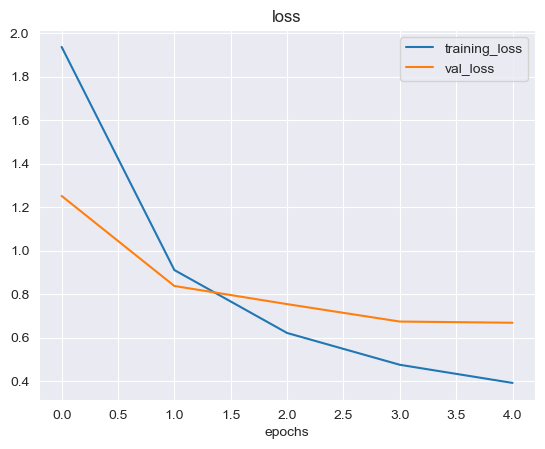

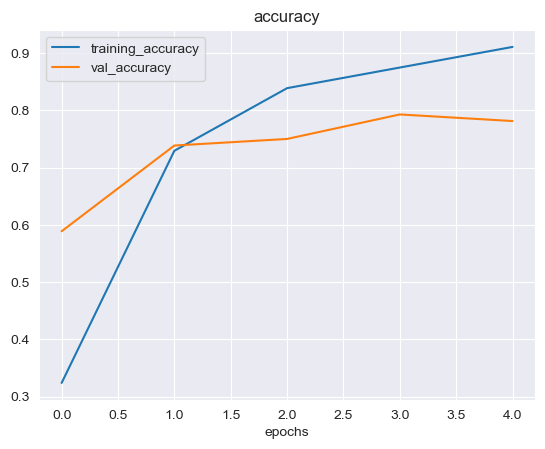

In [19]:
plot_loss(resnet_history)

In [20]:
efficientnet_model_test = create_model(model_url=efficientnet_url,
                                num_classes=train_data_10_percent.num_classes)

efficientnet_model_test.compile(loss='categorical_crossentropy',
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=['accuracy'])

efficientnet_history = efficientnet_model_test.fit(train_data_10_percent,
                                              epochs=10,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=int(0.25 * len(test_data)),
                                              callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                     experiment_name='efficientnetb0')])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20230409-162537
Epoch 1/10
24/24 [==============================] - 21s 797ms/step - loss: 1.8732 - accuracy: 0.4133 - val_loss: 1.3281 - val_accuracy: 0.7220
Epoch 2/10
24/24 [==============================] - 18s 758ms/step - loss: 1.0882 - accuracy: 0.7493 - val_loss: 0.9112 - val_accuracy: 0.8125
Epoch 3/10
24/24 [==============================] - 18s 763ms/step - loss: 0.7700 - accuracy: 0.8280 - val_loss: 0.7254 - val_accuracy: 0.8454
Epoch 4/10
24/24 [==============================] - 18s 767ms/step - loss: 0.6140 - accuracy: 0.8653 - val_loss: 0.5962 - val_accuracy: 0.8635
Epoch 5/10
24/24 [==============================] - 18s 771ms/step - loss: 0.5205 - accuracy: 0.8867 - val_loss: 0.5767 - val_accuracy: 0.8618
Epoch 6/10
24/24 [==============================] - 18s 774ms/step - loss: 0.4511 - accuracy: 0.9053 - val_loss: 0.5369 - val_accuracy: 0.8651
Epoch 7/10
24/24 [==============================] - 18s 770ms/s

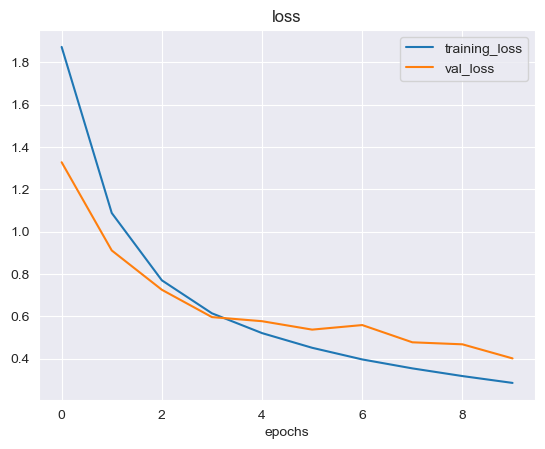

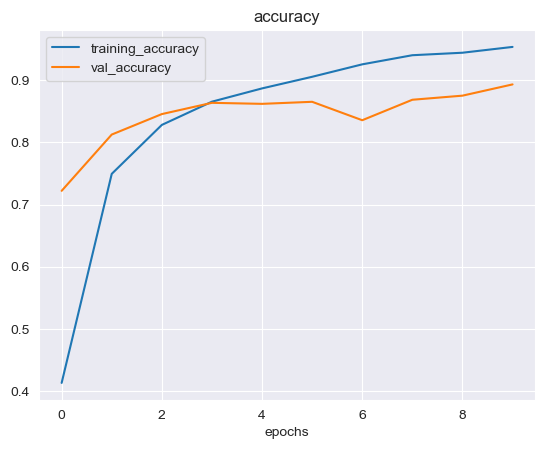

In [21]:
plot_loss(efficientnet_history)

In [22]:
len(efficientnet_model.layers[0].weights)

309

In [24]:
# !tensorboard dev upload --logdir ./tensorflow_hub/ \
#     --name "EfficientNetB0 vs ResNet50V2" \
#     --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
#     --one_shot # exits the tensorboard dev uploader once upload has finished



***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) ^C
Traceback (most recent call last):
  File "/Users/kinhanglo/Desktop/machine-learning/Machine-Learning-environment/env/bin/tensorboard", line 10, in <module>
    sys.exit(run_main())
  File "/Users/kinhanglo/Desktop/machine-learning/Machine-Learning-environment/env/lib/python3.10/site-packages/tensorboard/main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tenso